In [82]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import SelectKBest
import numpy as np
import pandas as pd
import datetime
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
import json

In [2]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Dataset/RestaurantRevenue')

In [3]:
!ls

restaurant-revenue-prediction.zip  test.csv	 train.csv
sampleSubmission.csv		   test.csv.zip  train.csv.zip


In [4]:
#!unzip restaurant-revenue-prediction.zip

In [5]:
#!unzip train.csv.zip

In [6]:
#!unzip test.csv.zip

In [7]:
train_dataset = pd.read_csv('train.csv')

In [8]:
train_dataset.head(10)

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0
5,5,02/12/2010,Ankara,Big Cities,FC,6,6.0,4.5,7.5,8,10,10,8,8,8,10,8,6.0,0,0,0,0,0,5,6,3,1,5,0,0,0.0,0.0,7.5,5.0,0,0,0,0,0,0,0,0,5017319.0
6,6,10/11/2010,İstanbul,Big Cities,IL,2,3.0,4.0,4.0,1,5,5,5,5,5,2,5,5.0,3,4,4,3,4,2,4,1,2,1,5,4,4.0,5.0,1.0,3.0,4,5,2,2,3,5,4,4,5166635.0
7,7,06/21/2011,İstanbul,Big Cities,IL,4,5.0,4.0,5.0,2,3,5,4,4,4,4,3,4.0,0,0,0,0,0,3,5,2,4,2,0,0,0.0,0.0,3.0,2.0,0,0,0,0,0,0,0,0,4491607.0
8,8,08/28/2010,Afyonkarahisar,Other,IL,1,1.0,4.0,4.0,1,2,1,5,5,5,1,5,5.0,1,1,2,1,4,1,1,1,1,1,4,4,4.0,2.0,2.0,3.0,4,5,5,3,4,5,4,5,4952497.0
9,9,11/16/2011,Edirne,Other,IL,6,4.5,6.0,7.5,6,4,10,10,10,10,2,10,7.5,0,0,0,0,0,25,3,3,1,10,0,0,0.0,0.0,5.0,2.5,0,0,0,0,0,0,0,0,5444227.0


In [9]:
#converting open date column to number of days on which the restaurant has been open from current date
train_dataset['Open Date']= pd.to_datetime(train_dataset['Open Date'],  format='%m/%d/%Y')
train_dataset['num_open_days'] = ''

In [10]:
train_dataset

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,num_open_days
0,0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,
1,1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,
2,2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,
3,3,2012-02-02,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,
4,4,2009-05-09,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,2008-06-25,Trabzon,Other,FC,2,3.0,3.0,5.0,4,2,4,4,4,4,4,4,4.0,0,0,0,0,0,4,3,2,1,1,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,5787594.0,
133,133,2006-10-12,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,3,5,4,4,5,5,4,5.0,0,0,0,0,0,3,2,2,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,9262754.0,
134,134,2006-07-08,Kayseri,Other,FC,3,4.0,4.0,4.0,2,3,5,5,5,5,1,5,5.0,0,0,0,0,0,2,3,1,2,2,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2544857.0,
135,135,2010-10-29,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,2,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,7217634.0,


In [11]:
today = pd.Timestamp.now().to_period('D')
today.to_timestamp().strftime("%Y-%m-%d")
print(today)

2021-03-29


In [12]:
#from today's date
last_date = pd.DataFrame({'Date':np.repeat(['03/29/2021'],[len(train_dataset)]) })
last_date['Date'] = pd.to_datetime(last_date['Date'], format='%m/%d/%Y')  

In [13]:
last_date['Date']

0     2021-03-29
1     2021-03-29
2     2021-03-29
3     2021-03-29
4     2021-03-29
         ...    
132   2021-03-29
133   2021-03-29
134   2021-03-29
135   2021-03-29
136   2021-03-29
Name: Date, Length: 137, dtype: datetime64[ns]

In [14]:
train_dataset['num_open_days'] = last_date['Date'] - train_dataset['Open Date']

In [15]:
#converting all dates to int
train_dataset['num_open_days'] = train_dataset['num_open_days'].astype('timedelta64[D]').astype(int)

In [16]:
train_dataset

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,num_open_days
0,0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,7926
1,1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,4792
2,2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,2942
3,3,2012-02-02,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,3343
4,4,2009-05-09,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,4342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,2008-06-25,Trabzon,Other,FC,2,3.0,3.0,5.0,4,2,4,4,4,4,4,4,4.0,0,0,0,0,0,4,3,2,1,1,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,5787594.0,4660
133,133,2006-10-12,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,3,5,4,4,5,5,4,5.0,0,0,0,0,0,3,2,2,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,9262754.0,5282
134,134,2006-07-08,Kayseri,Other,FC,3,4.0,4.0,4.0,2,3,5,5,5,5,1,5,5.0,0,0,0,0,0,2,3,1,2,2,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2544857.0,5378
135,135,2010-10-29,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,2,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,7217634.0,3804


In [17]:
#dropping open date
train_dataset = train_dataset.drop('Open Date', axis=1)

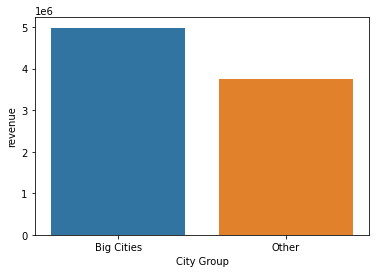

In [18]:
#compairing revenue of big cities with respect to others
revenue_percentage = train_dataset[["City Group", "revenue"]].groupby(['City Group'],as_index=False).mean()
sns.barplot(x='City Group', y='revenue', data=revenue_percentage)

In [19]:
revenue_percentage

,City Group,revenue
0,Big Cities,4.983480e+06
1,Other,3.752924e+06


              City       revenue
31        İstanbul  5.577812e+06
12          Elazığ  5.525735e+06
11          Edirne  5.444227e+06
32           İzmir  5.287571e+06
29         Trabzon  5.284100e+06
1   Afyonkarahisar  4.952497e+06
0            Adana  4.894944e+06
6        Balıkesir  4.758476e+06
18         Kayseri  4.567576e+06
14       Gaziantep  4.316715e+06
7             Bolu  4.263629e+06
23           Muğla  4.111129e+06
8            Bursa  4.092295e+06
15         Isparta  4.015749e+06
13       Eskişehir  3.957953e+06
16         Karabük  3.807496e+06
19         Kocaeli  3.745135e+06
10      Diyarbakır  3.735351e+06
4          Antalya  3.481448e+06
5            Aydın  3.429798e+06
24        Osmaniye  3.376145e+06
25         Sakarya  3.328853e+06
27        Tekirdağ  3.312471e+06
3           Ankara  3.275406e+06
17       Kastamonu  3.273041e+06
33       Şanlıurfa  3.261924e+06
26          Samsun  3.247870e+06
21         Kütahya  2.993069e+06
2           Amasya  2.954086e+06
28        

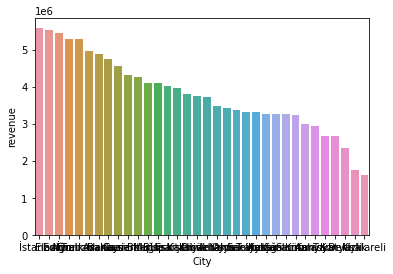

In [20]:
#sorting the cities by revenue earned
revenue_percentage = train_dataset[["City", "revenue"]].groupby(["City"], as_index=False).mean()
sorted_revenue= revenue_percentage.sort_values(["revenue"], ascending=False)
#printing the data to be more clear
sns.barplot(x='City', y = 'revenue', data= sorted_revenue)
print(sorted_revenue)

In [21]:
#dropping the unneccessary columns from the dataset
train_dataset = train_dataset.drop('Id', axis=1)
train_dataset = train_dataset.drop('Type',axis=1)

In [22]:
#converting city group to categorical data
city_group = pd.get_dummies(train_dataset['City Group'])
train_dataset = train_dataset.join(city_group)
#dropping the non categorical variables
train_dataset = train_dataset.drop('City Group', axis=1)
train_dataset = train_dataset.drop('City', axis=1)
#dropping the revenue column and taking it as label
revenue = train_dataset['revenue']
train_dataset = train_dataset.drop('revenue', axis=1)


In [23]:
train_dataset

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,num_open_days,Big Cities,Other
0,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,7926,1,0
1,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,4792,1,0
2,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2942,0,1
3,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,3343,0,1
4,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4342,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2,3.0,3.0,5.0,4,2,4,4,4,4,4,4,4.0,0,0,0,0,0,4,3,2,1,1,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,4660,0,1
133,4,5.0,4.0,4.0,2,3,5,4,4,5,5,4,5.0,0,0,0,0,0,3,2,2,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,5282,1,0
134,3,4.0,4.0,4.0,2,3,5,5,5,5,1,5,5.0,0,0,0,0,0,2,3,1,2,2,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,5378,0,1
135,4,5.0,4.0,5.0,2,2,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,3804,1,0


In [24]:
revenue

0      5653753.0
1      6923131.0
2      2055379.0
3      2675511.0
4      4316715.0
         ...    
132    5787594.0
133    9262754.0
134    2544857.0
135    7217634.0
136    6363241.0
Name: revenue, Length: 137, dtype: float64

In [25]:
features = train_dataset.iloc[:,1:].values

In [26]:
#splitting the data
X_train,X_test, y_train,y_test = train_test_split(features,revenue, test_size=0.25, random_state=42)

In [27]:
#printing the shape
print("shape of training features", np.shape(X_train))
print("shape of training labels", np.shape(y_train))
print("shape of testing features", np.shape(X_test))
print("shape of testing_labels", np.shape(y_test))


shape of training features (102, 39)
shape of training labels (102,)
shape of testing features (35, 39)
shape of testing_labels (35,)


In [28]:
#applying standard scaler for feature scaling
StandardScaler_instance = StandardScaler(with_std  = True ,with_mean = True, copy = True)
X_train = StandardScaler_instance.fit_transform(X_train)
X_test = StandardScaler_instance.fit_transform(X_test)

In [29]:
#fetching the keys for hyperparameter tuning
print("Hyperparams of Random Forest Regressor are",RandomForestRegressor().get_params().keys())

Hyperparams of Random Forest Regressor are dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])


In [43]:
# number of folds for cross-validation
n_folds = 3
grid_params = {'n_estimators':[10,100,500,1000],  'max_features':[3,5,7]} 
random_forest = GridSearchCV(RandomForestRegressor(), grid_params,verbose=1, cv=n_folds, n_jobs=8).fit(X_train, y_train).best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  21 out of  36 | elapsed:    7.2s remaining:    5.2s
[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:   17.8s finished


In [44]:
random_forest.score(X_test,y_test)

0.12250663469407119

# Observation
The score is not appreciable.  Let's try more feature engineering

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


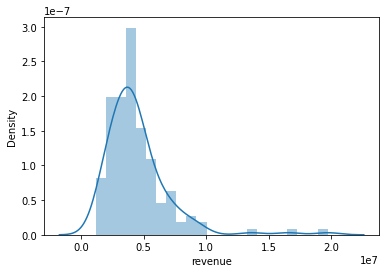

In [45]:
#let's check the distribution of output variable
sns.distplot((revenue))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


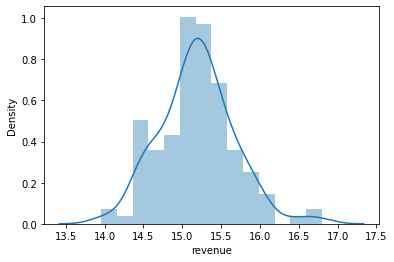

In [46]:
#as observed, it is end tailed
#let's take log of it
sns.distplot(np.log(revenue))

# Observation
Much better distribution of output variable. Let's convert the output variable to natural log.

In [47]:
log_revenue = np.log(revenue)

Let's check the same for input features



Skewness  P1               1.841412
P2               0.040052
P3               0.145334
P4               1.035630
P5               2.414260
P6               1.562815
P7               0.669055
P8               1.474332
P9               1.726721
P10              1.724929
P11              1.324262
P12              1.403638
P13              1.164095
P14              2.879644
P15              2.011790
P16              2.223015
P17              3.451736
P18              1.973559
P19              2.503242
P20              1.642048
P21              2.729971
P22              0.806967
P23              3.276060
P24              1.774883
P25              2.200606
P26              2.149265
P27              2.456601
P28              1.920551
P29              1.541544
P30              2.879599
P31              2.288791
P32              2.916353
P33              1.241610
P34              2.719279
P35              1.985279
P36              2.433065
P37              1.576096
num_open_days    1.473478
Bi

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


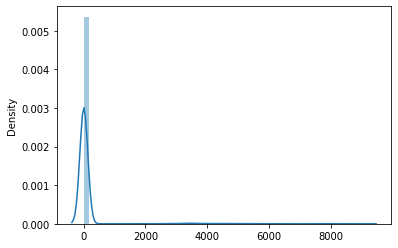

In [48]:
print("Skewness ", train_dataset.skew())
print("******************************")
print("Kurtosis", train_dataset.kurt())
sns.distplot((train_dataset))

In [49]:
X_train1,X_test1, y_train1,y_test1 = train_test_split(features,log_revenue, test_size=0.25, random_state=42)

In [50]:
#applying standard scaler for feature scaling
#removing mean and scaling to unit variance
StandardScaler_instance = StandardScaler(with_std  = True ,with_mean = True, copy = True)
X_train1 = StandardScaler_instance.fit_transform(X_train1)
X_test1 = StandardScaler_instance.fit_transform(X_test1)

In [51]:
#printing the shape
print("shape of training features", np.shape(X_train1))
print("shape of training labels", np.shape(y_train1))
print("shape of testing features", np.shape(X_test1))
print("shape of testing_labels", np.shape(y_test1))

shape of training features (102, 39)
shape of training labels (102,)
shape of testing features (35, 39)
shape of testing_labels (35,)


In [52]:
# number of folds for cross-validation
n_folds = 3
grid_params = {'n_estimators':[10,100,1000],  'max_features':[3,5,7]} 
random_forest = GridSearchCV(RandomForestRegressor(), grid_params,verbose=1, cv=n_folds, n_jobs=8).fit(X_train1, y_train1).best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:   12.4s finished


In [78]:
random_forest.score(X_train1,y_train1)

0.8849382389294221

In [79]:
random_forest.score(X_test1, y_test1)

0.25115670831130876

In [83]:
#saving the model for serving
with open('model.pkl','wb') as f:
    pickle.dump(random_forest,f)

# Observation
much better score on training and testing data!!
Let's try to increase more.

Let's use random forest classifier to select the best features for training.

In [57]:
from sklearn.ensemble import RandomForestClassifier
RC = RandomForestClassifier(n_estimators=500, random_state=42)
#labels
labels = train_dataset.columns[1:40]
RC.fit(X_train, y_train)
#important features
important = RC.feature_importances_
#sorting the indices with best importances first
indices = np.sort(important)[::-1]

In [58]:
#printing the features along with their score
for idx in range(len(labels)):
  print("{0} : {1}".format(labels[idx], important[idx]))


P2 : 0.04308582937558553
P3 : 0.0330692092350173
P4 : 0.032186461079157715
P5 : 0.0349787771418293
P6 : 0.04491348954588712
P7 : 0.015080821786251227
P8 : 0.02942694133364186
P9 : 0.01923199229819522
P10 : 0.01905401561102031
P11 : 0.046249276997707804
P12 : 0.027617066877622318
P13 : 0.02229350879233698
P14 : 0.016663845535744154
P15 : 0.01394326619812433
P16 : 0.014845536802067407
P17 : 0.013911700798359926
P18 : 0.008946287357539022
P19 : 0.04494897128348221
P20 : 0.042968194832255203
P21 : 0.026885088164669106
P22 : 0.04237599760602108
P23 : 0.03160402100448396
P24 : 0.014393156852052943
P25 : 0.014147437269803033
P26 : 0.01437179794199817
P27 : 0.01633381065385587
P28 : 0.04447908972576868
P29 : 0.03351594530646638
P30 : 0.014629830525736291
P31 : 0.013435329860220793
P32 : 0.015556909203515176
P33 : 0.014695747366382393
P34 : 0.012151831566609358
P35 : 0.010677447533707753
P36 : 0.011420816156077358
P37 : 0.015312476928531774
num_open_days : 0.09228488296961375
Big Cities : 0.019

#Observation
After feature P17, the score is very less. So we will use P1 to P17.

In [59]:
pruned_features = train_dataset[labels[1:18]]
pruned_features.head()

,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19
0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5
1,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3
2,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1
3,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20
4,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2


In [60]:
X_train2,X_test2, y_train2,y_test2 = train_test_split(pruned_features,log_revenue, test_size=0.25, random_state=42)

In [61]:
#applying standard scaler for feature scaling
#removing mean and scaling to unit variance
StandardScaler_instance = StandardScaler(with_std  = True ,with_mean = True, copy = True)
X_train2 = StandardScaler_instance.fit_transform(X_train2)
X_test2= StandardScaler_instance.fit_transform(X_test2)

In [62]:
#printing the shape
print("shape of training features", np.shape(X_train2))
print("shape of training labels", np.shape(y_train2))
print("shape of testing features", np.shape(X_test2))
print("shape of testing_labels", np.shape(y_test2))

shape of training features (102, 17)
shape of training labels (102,)
shape of testing features (35, 17)
shape of testing_labels (35,)


In [66]:
n_folds = 3
grid_params = {'n_estimators':[10,100,1000],  'max_features':[3,5,7]} 
random_forest_new = GridSearchCV(RandomForestRegressor(), grid_params,verbose=1, cv=n_folds, n_jobs=8).fit(X_train2, y_train2).best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:   12.4s finished


In [77]:
random_forest_new.score(X_train2,y_train2)

0.7777988813305134

# Observation
Not much increment in the score either.
Let's use PCA

In [70]:
from sklearn.decomposition import PCA,KernelPCA

pca1 = PCA(n_components=2,svd_solver='full')
X_train_pca = pca1.fit_transform(X_train2)
X_test_pca = pca1.transform(X_test2)
print(pca1.explained_variance_ratio_)
#applying RBF to have linearity in the data, since we have non-linear data.
pca2 = KernelPCA(kernel="rbf", gamma=1)
X_pca2_train = pca2.fit_transform(X_train2)
X_pca2_test = pca2.transform(X_test2)

[0.56349178 0.18829115]


Text(0.5, 0, 'After RBF')

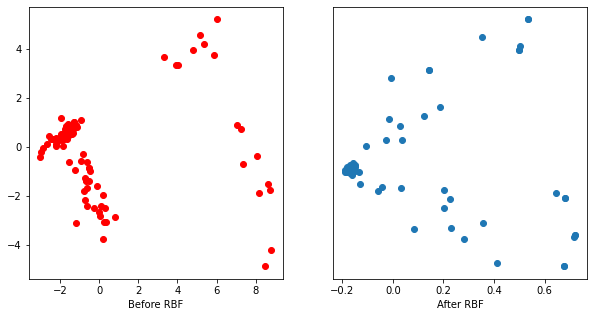

In [73]:
#let's plot sample variance before and after RBF
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
ax[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1],color='red',marker='o')
ax[1].scatter(X_pca2_train[:, 0], X_pca2_train[:, 1])
ax[0].set_xlabel('Before RBF')
ax[1].set_yticks([])
ax[1].set_xlabel('After RBF')

In [74]:
n_folds = 3
grid_params = {'n_estimators':[10,100,1000],  'max_features':[3,5,7]} 
random_forest_pca = GridSearchCV(RandomForestRegressor(), grid_params,verbose=1, cv=n_folds, n_jobs=8).fit(X_pca2_train, y_train2).best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:   17.9s finished


In [76]:
random_forest_pca.score(X_pca2_train,y_train2)

0.7922369949634529